In [23]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
import seaborn as sns
import os
import pickle

from scipy.stats import gaussian_kde

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras.metrics import Metric
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
#from plot_keras_history import plot_history
import tqdm
from tqdm import tqdm

os.chdir(r'C:\Users\donov\Downloads\Northwestern\MSDS 422 Machine Learning\Anaconda Working Directory')

# Helper Functions
## Plotting

In [24]:
# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size 
    y = n%size
    return x,y

In [25]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 

In [26]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [27]:
def pca_plot(X_train,  pca_features):
    pca= PCA(n_components = pca_features )
    pca_transform_train = pca.fit_transform(X_train)
    
    explained_variance = pca.explained_variance_ratio_
    var_exp = explained_variance.sum()
    plt.figure()
    plt.plot(np.cumsum(explained_variance))
    plt.xlabel('Number of Componentns')
    plt.ylabel('Percent Variance')
    plt.title(f'Variance Explained {round(var_exp*100,2)}%')
    plt.show()
    
    pca_df = pd.concat([pd.DataFrame(data={'Principle Comp': np.arange(0,X_train.shape[0])}),
                       pd.DataFrame(data={'Variance Squared': explained_variance**2})],
                      axis=1).sort_values(by='Variance Squared', ascending=False)[0:pca_features]
    
    return display(pca_df )

In [28]:
def act_box_plot(df):
    for node in range(0,len(df.T)-1,1):
        plt.figure(figsize=(20,10))


        plt.subplot(2,2,node+1)
        # Uses provided code to get activation_df then filters for the class 
        class_activation = activation_df[f'act_val_{node}']
        bplot = sns.boxplot(y=f'act_val_{node}', x='actual_class', 
                         data=df[[f'act_val_{node}','actual_class']], 
                         width=0.5,
                         palette="colorblind")
        plt.xticks(size=14)
        plt.yticks(size=14)
        plt.xlabel('Handwritten Digit', size=14)
        plt.ylabel('Activation Value', size=14)
        

In [66]:
def plot_tsne(model, X_value, X_train, y_train):
    '''
    Both the X_train with dim reduction and X_train without are needed to plot samples
    '''
    act_df, acts = get_activations(model, X_value, y_train)
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(act_df)
    tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())
    cmap = plt.cm.tab10
    plt.figure(figsize=(16,10))
    plt.scatter(tsne_results[:,0],tsne_results[:,1], c=y_train, s=10, cmap=cmap)

    image_positions = np.array([[1., 1.]])
    for index, position in enumerate(tsne_results):
        dist = np.sum((position - image_positions) ** 2, axis=1)
        if np.min(dist) > 0.02: # if far enough from other images
            image_positions = np.r_[image_positions, [position]]
            imagebox = mpl.offsetbox.AnnotationBbox(
                mpl.offsetbox.OffsetImage(X_train[index].reshape(28,28), cmap="binary"),
                position, bboxprops={"edgecolor": cmap(y_train[index]), "lw": 2})
            plt.gca().add_artist(imagebox)
    plt.title('t-SNE Plot with Descriptions')
    plt.axis("off")
    plt.show();

In [30]:
def plot_metrics(model, hist, X_test):
    losses = hist.history['loss']
    accs = hist.history['accuracy']
    val_losses = hist.history['val_loss']
    val_accs = hist.history['val_accuracy']
    epochs = len(losses)
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()

    plt.figure(figsize=(2,2))
    preds = model.predict(X_test)
    pred_classes = np.argmax(model.predict(X_test), axis=-1)
    conf_mx = tf.math.confusion_matrix(np.argmax(y_test, axis=1), pred_classes)
    cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
    df = pd.DataFrame(preds[0:5], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])


    plot_confusion_matrix(np.argmax(y_test, axis=1),pred_classes)


    plt.show()


    display(df.style.format("{:.2%}").background_gradient(cmap=cm).set_caption('Five predictions with probability per class:'))


In [31]:
def act_scatter_plot(X_test, y_train):
    pixel_data = {'actual_class':np.argmax(y_train,axis=1)}
    for k in range(0,X_test.shape[1]): 
        pixel_data[f"pix_val_{k}"] = X_train[:,k]
    pixel_df = pd.DataFrame(pixel_data)
    pixel_df.head(15).round(3).T
    plt.title('Confusion Matrix')
    plt.figure(figsize=(8, 8))
    color = sns.color_palette("hls", 10)
    for pixle in range(X_test.shape[1]):
        sns.scatterplot(x=f'pix_val_{pixle}', 
                        y=f'pix_val_{pixle+1}', 
                        hue="actual_class",  
                        palette=color, 
                        data = pixel_df, 
                        legend="full")
        plt.legend(loc='upper left');
    plt.show()

## Modeling

In [32]:
################ NEW
#https://towardsdatascience.com/f-beta-score-in-keras-part-ii-15f91f07c9a4
class StatefullMultiClassFBeta(Metric):
  def __init__(self, name='state_full_binary_fbeta', beta=1, n_class=10, average='macro', epsilon=1e-7, **kwargs):
    # initializing an object of the super class
    super(StatefullMultiClassFBeta, self).__init__(name=name, **kwargs)

    # initializing state variables
    self.tp = self.add_weight(name='tp', shape=(n_class,), initializer='zeros')     # initializing true positives
    self.actual_positives = self.add_weight(name='ap', shape=(n_class,), initializer='zeros') # initializing actual positives
    self.predicted_positives = self.add_weight(name='pp', shape=(n_class,), initializer='zeros') # initializing predicted positives

    # initializing other atrributes that wouldn't be changed for every object of this class
    self.beta_squared = beta**2
    self.n_class = n_class
    self.average = average
    self.epsilon = epsilon

  def update_state(self, ytrue, ypred, sample_weight=None):
    # casting ytrue and ypred as float dtype
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(ypred, tf.float32)

    # finding the maximum probability in ypred
    max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)

    # making ypred one hot encoded such that the class with the maximum probability as encoded as 1 while others as 0
    ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)
        
    self.tp.assign_add(tf.reduce_sum(ytrue*ypred, axis=0)) # updating true positives atrribute
    self.predicted_positives.assign_add(tf.reduce_sum(ypred, axis=0)) # updating predicted positives atrribute
    self.actual_positives.assign_add(tf.reduce_sum(ytrue, axis=0)) # updating actual positives atrribute

  def result(self):
    self.precision = self.tp/(self.predicted_positives+self.epsilon) # calculates precision
    self.recall = self.tp/(self.actual_positives+self.epsilon) # calculates recall

    # calculating fbeta score
    self.fb = (1+self.beta_squared)*self.precision*self.recall / (self.beta_squared*self.precision + self.recall + self.epsilon)

    if self.average == 'weighted':
      return tf.reduce_sum(self.fb*self.actual_positives / tf.reduce_sum(self.actual_positives))
    
    elif self.average == 'raw':
      return self.fb

    return tf.reduce_mean(self.fb)

  def reset_states(self):
    self.tp.assign(tf.zeros(self.n_class)) # resets true positives to zero
    self.predicted_positives.assign(tf.zeros(self.n_class)) # resets predicted positives to zero
    self.actual_positives.assign(tf.zeros(self.n_class)) # resets actual positives to zero

In [33]:
def create_model(input_nodes, hid_nodes, activation, learning_rate, beta_1, epsilon, optimizer): #optimizer instead of 
    statefull_multi_class_fbeta = StatefullMultiClassFBeta()
    #optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate, 
    #                                      beta_1=beta_1, 
    #                                      epsilon=epsilon, 
    #                                      name='Nadam')
    model = Sequential([
        Dense(name = 'input_and_hidden_layer',
              input_shape=[input_nodes], 
              units=hid_nodes, 
              activation = activation,
              kernel_regularizer=tf.keras.regularizers.L2(0.001)),
        Dense(name = "output_layer", 
              units = 10, 
              activation = tf.nn.softmax)
    ])
    
    model.compile(optimizer=optimizer,           
                   loss = 'categorical_crossentropy',
                   metrics=[ 'accuracy', statefull_multi_class_fbeta]
    )

    return model 

In [34]:
#NEW 
def run_experiment(model, model_name, epochs, data_import_list, batch_size):
                    
    #Converts external train/test split data that may be named differently
    # into a common data element for this function
    
    train = data_import_list[0]
    val = data_import_list[1]
    test = data_import_list[2]
    hist= model.fit(train, 
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                                patience=4), 
                               tf.keras.callbacks.ModelCheckpoint(model_name,   
                                                                monitor='val_accuracy',
                                                                verbose=0,
                                                                save_best_only=True,
                                                                save_weights_only=True,
                                                                mode="auto",
                                                                save_freq="epoch"
)])

        
    results = []
 
    best_val_accuracy_index = np.argmax(hist.history['val_accuracy'])
    for key in hist.history.keys():
        results.append(hist.history[key][best_val_accuracy_index])

    # Evaluate test
    loss, accuracy, f1 = model.evaluate(test, y_test)
    results.extend([loss, accuracy, f1])
    return hist, results

In [35]:
### new
def experiment_loop(experiment_name, data_import_list, iter_dict, input_nodes, epochs):
    experiment_counter = int()
    model_list, hist_list, model_name_list = [],[],[]
    for param in iter_dict:
        experiment_counter +=1
        param_list = []

        hid_nodes = param['hid_nodes']
        batch_size = param['batch_size']
        optimizer = 'NADAM' 
        #optimizer= param['optimizer']
        activation = param['activation']
        learning_rate = param['learning_rate']
        beta_1 = param['beta_1']
        epsilon = param['epsilon']
        model_name = experiment_name + " " + str(experiment_counter)

        model = create_model(input_nodes, hid_nodes, activation, learning_rate, beta_1, epsilon, optimizer)
        hist, results = run_experiment(model, model_name, epochs, data_import_list, batch_size)
        epoch_count = len(hist.history['loss'])
        
        results = [round(result,3) for result in results]
        param_list.extend([model_name, 
                           hid_nodes, 
                           str(activation), 
                           epoch_count, 
                           optimizer, 
                           batch_size,
                           learning_rate,
                           beta_1,
                           epsilon
        ])
        metrics_param_list =  param_list + results
        if experiment_counter == 1:
            results_df = pd.DataFrame([metrics_param_list],columns = ['Experiment Name',
                                                              'Hidden Nodes', 
                                                              'Activation',
                                                              'Completed Epochs',   
                                                              'Optimizer',
                                                              'batch_size',
                                                              'Learning Rate',
                                                              'Beta 1',
                                                              'Epsilon',
                                                              'loss', 
                                                              'acc', 
                                                              'F1', 
                                                              'val_loss', 
                                                              'val_acc',
                                                              'val_F1', 
                                                              'test_loss', 
                                                              'test_acc', 
                                                              'test_F1',
                                                           
            ])
        else:
            df_length = len(results_df)
            results_df.loc[df_length] = metrics_param_list
        
    return results_df, model, hist, model_name

In [46]:
def get_activations(model, X_values, y_values):

    y_values = y_values
    # Extracts the outputs of the 2 layers:
    layer_outputs = [layer.output for layer in model.layers]

    # Creates a model that will return these outputs, given the model input:
    activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

    
    layer_outputs; # description of the layers
    # Get the outputs of all the hidden nodes for each of the 60000 training images
    activations = activation_model.predict(X_values)
    hidden_layer_activation = activations[0]
    output_layer_activations = activations[1]
    hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image
    #Get the dataframe of all the node values
    activation_data = {'actual_class':y_values}
    for k in range(0,len(hidden_layer_activation.T)): 
        activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

    activation_df = pd.DataFrame(activation_data)
    activation_df.head(15).round(3).T

    return activation_df, hidden_layer_activation

# Import Data, EDA, Preprocessing
Import data, check for imbalance, train/test split, and normalize

In [15]:
# Import Data
(X_train, y_train), (X_test, y_test)= tf.keras.datasets.mnist.load_data()
# Used for plotting images
y_train_scalar = np.delete(y_train, slice(5000), 0)

In [16]:
# Check for imbalance in train and test data
pd.DataFrame(list(zip(Counter(y_train).most_common(), 
                      Counter(y_test).most_common()
            )),
            columns=['y_train', 'y_test']
)

,y_train,y_test
0,"(1, 6742)","(1, 1135)"
1,"(7, 6265)","(2, 1032)"
2,"(3, 6131)","(7, 1028)"
3,"(2, 5958)","(3, 1010)"
4,"(9, 5949)","(9, 1009)"
5,"(0, 5923)","(4, 982)"
6,"(6, 5918)","(0, 980)"
7,"(8, 5851)","(8, 974)"
8,"(4, 5842)","(6, 958)"
9,"(5, 5421)","(5, 892)"


In [17]:
# Reshape and normalize data
X_train = X_train.reshape(60000,784) /255
X_test = X_test.reshape(10000,784) /255

# Create validation split
X_val = X_train[:5000]
y_val = y_train[:5000]
X_train = np.delete(X_train, slice(5000), 0)
y_train = np.delete(y_train, slice(5000), 0)



# one-hot encode y values
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Prepared lists of independent variable sets for helper functions
data_list = [X_train , X_val, X_test]

In [18]:
# Confirm data shape
arrays = [X_train, y_train, X_val, y_val, X_test, y_test]
array_names = ['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test']
for array, array_name in zip(arrays, array_names):
    print(f'{array_name} shape: {array.shape}')

X_train shape: (55000, 784)
y_train shape: (55000, 10)
X_val shape: (5000, 784)
y_val shape: (5000, 10)
X_test shape: (10000, 784)
y_test shape: (10000, 10)


In [19]:
print(f' First 5 rows of y_test: \n{y_test[:5]} \n')
print(f' First 5 rows of y_train: \n{y_train[:5,]}')

 First 5 rows of y_test: 
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] 

 First 5 rows of y_train: 
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


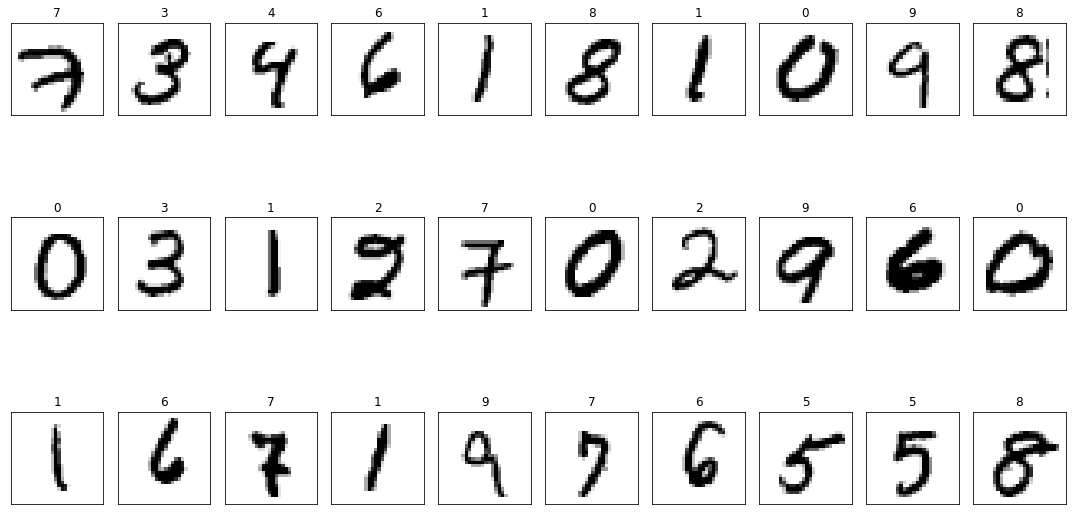

In [29]:
# Print first 30 test images
fig = plt.figure(figsize = (15, 9))

for i in range(30):
    plt.subplot(3, 10, 1+i)
    plt.title(np.argmax(y_train[i]))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i].reshape(28,28), cmap='binary')
plt.tight_layout()

# Modeling
Explore five predefined experiments as requested

## Experiment 1 - Single Hidden Node

In [164]:
# Full 784 input dims - No reduction
# Search space for hyperparameters
params = {'hid_nodes': [1], 
          'batch_size': [32], 
          'activation':[tf.nn.relu],       
          'learning_rate':[0.0095],
          'epsilon':[0.48],
          'beta_1':[0.9]}
iter_dict = [dict(zip(params, v)) for v in product(*params.values())]
full_dim_results_df, best_model_1, best_hist_1, best_model_name = experiment_loop('None', 
                                                                                  data_list, 
                                                                                  iter_dict, 
                                                                                  input_nodes = 784, 
                                                                                  epochs = 150)

Train on 55000 samples, validate on 5000 samples
Epoch 1/150
55000/55000 [==============================] - 18s 333us/sample - loss: 1.9891 - accuracy: 0.2143 - state_full_binary_fbeta: 0.1259 - val_loss: 1.8390 - val_accuracy: 0.2374 - val_state_full_binary_fbeta: 0.1275
Epoch 2/150
55000/55000 [==============================] - 26s 466us/sample - loss: 1.7969 - accuracy: 0.2609 - state_full_binary_fbeta: 0.1493 - val_loss: 1.7534 - val_accuracy: 0.2700 - val_state_full_binary_fbeta: 0.1512
Epoch 3/150
55000/55000 [==============================] - 18s 325us/sample - loss: 1.7400 - accuracy: 0.2890 - state_full_binary_fbeta: 0.1714 - val_loss: 1.7091 - val_accuracy: 0.2928 - val_state_full_binary_fbeta: 0.1729
Epoch 4/150
55000/55000 [==============================] - 26s 466us/sample - loss: 1.7017 - accuracy: 0.2985 - state_full_binary_fbeta: 0.1833 - val_loss: 1.6816 - val_accuracy: 0.2996 - val_state_full_binary_fbeta: 0.1838
Epoch 5/150
55000/55000 [==============================

In [165]:
full_dim_results_df

,Experiment Name,Hidden Nodes,Activation,Completed Epochs,Optimizer,batch_size,Learning Rate,Beta 1,Epsilon,loss,acc,F1,val_loss,val_acc,val_F1,test_loss,test_acc,test_F1
0,None 1,1,<function relu at 0x00000222971E5A68>,21,NADAM,32,0.0095,0.9,0.48,1.579,0.37,0.254,1.575,0.373,0.254,1.581,0.379,0.27


Boxplot shows the distributions of the hidden layer activation values for each class 

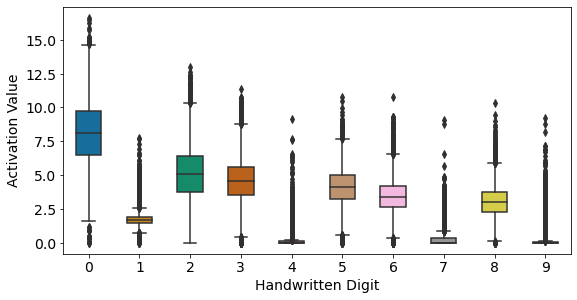

In [177]:
activations_single_node, acts = get_activations(best_model_1, X_train, y_train)

act_box_plot(activations_single_node)


Model performance metrics how the loss/learning process, the confusion matrix (true positive vs false positive), and the stregnth/confidence of the first five predictions for this model

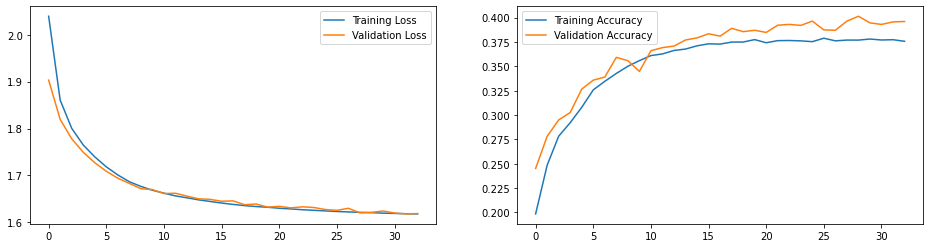

<Figure size 144x144 with 0 Axes>

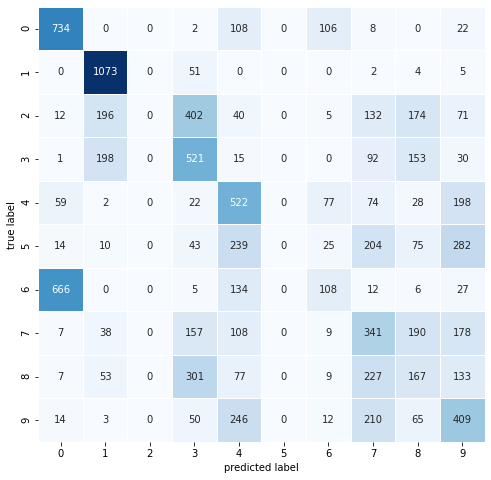

,0,1,2,3,4,5,6,7,8,9
0,0.02%,2.23%,18.86%,18.11%,2.96%,8.74%,0.07%,18.10%,20.05%,10.86%
1,2.16%,0.09%,6.78%,4.53%,18.92%,18.78%,3.74%,15.05%,9.77%,20.18%
2,0.00%,49.69%,13.67%,22.85%,0.03%,0.41%,0.00%,3.62%,9.10%,0.63%
3,44.77%,0.00%,0.08%,0.03%,10.61%,2.44%,39.19%,0.55%,0.17%,2.16%
4,1.09%,0.16%,8.77%,6.23%,15.04%,17.96%,2.06%,16.90%,12.01%,19.78%


In [365]:
plot_metrics(best_model_1, best_hist_1)

The t-SNE plot shows how well classifications are clustered

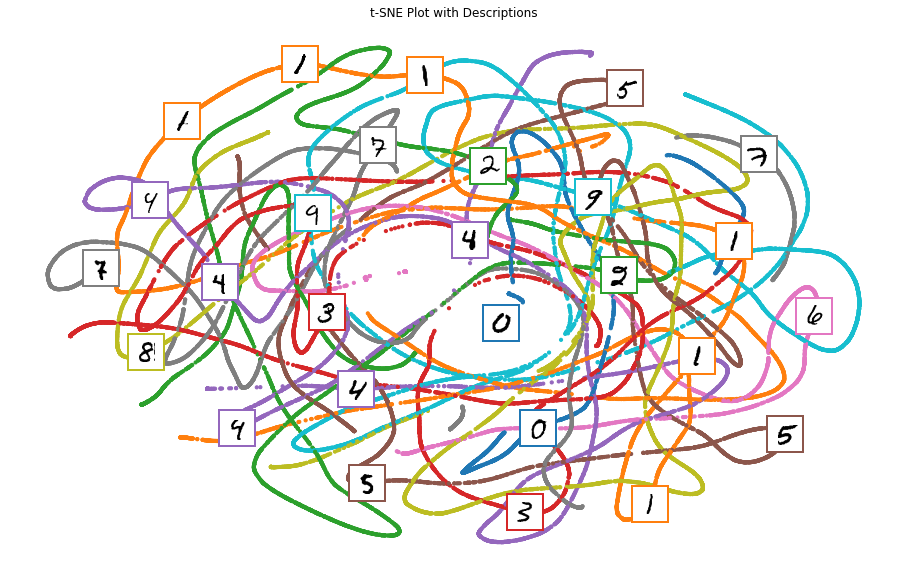

In [368]:
plot_tsne(best_model_1, X_train, y_train)

In [94]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:

# Build a loss function that maximizes the activation
# of the nth filter of the layer considered.
K = tf.keras.backend
layer_output = pca_model.get_layer('input_and_hidden_layer').output
loss = K.mean(layer_output)

# Compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, pca_model.input)[0]

# Normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# This function returns the loss and grads given the input picture
iterate = K.function([pca_model.input], [loss, grads])

# We start from a gray image with some noise
input_img_data = np.random.random((1, 28*28)) * 20 + 128.

# Run gradient ascent for 1000 steps
step = 1.
for i in range(1000):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step


img = input_img_data[0]

# Find and display the pattern that maximizes the activation value
max_img = generate_pattern('input_and_hidden_layer')
plt.imshow(max_img.reshape(28,28), cmap="binary")
plt.axis('off')

plt.show()

# Experiment 2 - Two Hidden Nodes

In [179]:
# Full 784 input dims - No reduction
# Search space for hyperparameters
params = {'hid_nodes': [2], 
          'batch_size': [32], 
          'activation':[tf.nn.relu],       
          'learning_rate':[0.0095],
         # 'optimizer':['nadam'],
          'epsilon':[0.48],
          'beta_1':[0.9]}
iter_dict = [dict(zip(params, v)) for v in product(*params.values())]
full_dim_results_df, best_model_2, best_hist_2, best_model_name = experiment_loop('None', 
                                                                                  data_list, 
                                                                                  iter_dict, 
                                                                                  input_nodes = 784, 
                                                                                  epochs = 150)

Train on 55000 samples, validate on 5000 samples
Epoch 1/150
55000/55000 [==============================] - 27s 487us/sample - loss: 1.8017 - accuracy: 0.3367 - state_full_binary_fbeta: 0.2400 - val_loss: 1.5613 - val_accuracy: 0.4210 - val_state_full_binary_fbeta: 0.2480
Epoch 2/150
55000/55000 [==============================] - 18s 334us/sample - loss: 1.4528 - accuracy: 0.4684 - state_full_binary_fbeta: 0.3224 - val_loss: 1.3404 - val_accuracy: 0.4942 - val_state_full_binary_fbeta: 0.3276
Epoch 3/150
55000/55000 [==============================] - 26s 481us/sample - loss: 1.3209 - accuracy: 0.5072 - state_full_binary_fbeta: 0.3733 - val_loss: 1.2550 - val_accuracy: 0.5482 - val_state_full_binary_fbeta: 0.3783
Epoch 4/150
55000/55000 [==============================] - 26s 477us/sample - loss: 1.2388 - accuracy: 0.5543 - state_full_binary_fbeta: 0.4162 - val_loss: 1.1609 - val_accuracy: 0.5948 - val_state_full_binary_fbeta: 0.4198
Epoch 5/150
55000/55000 [==============================

In [184]:
full_dim_results_df

,Experiment Name,Hidden Nodes,Activation,Completed Epochs,Optimizer,batch_size,Learning Rate,Beta 1,Epsilon,loss,acc,F1,val_loss,val_acc,val_F1,test_loss,test_acc,test_F1
0,None 1,2,<function relu at 0x00000222971E5A68>,17,NADAM,32,0.0095,0.9,0.48,0.993,0.702,0.597,0.959,0.725,0.598,0.993,0.706,0.623


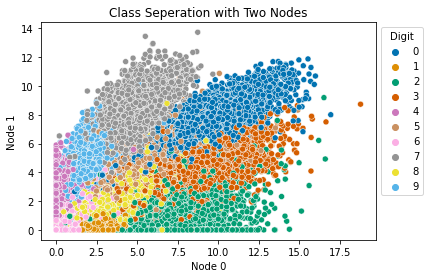

In [183]:
act_df, acts = get_activations(best_model_2, X_train, y_train)
sns.scatterplot(x='act_val_0', 
                y='act_val_1',
                hue="actual_class",  
                palette='colorblind', 
                data = act_df, 
                legend="full")
plt.xlabel('Node 0')
plt.ylabel('Node 1')
plt.title('Class Seperation with Two Nodes')
plt.legend(bbox_to_anchor=(1,1), title='Digit' );

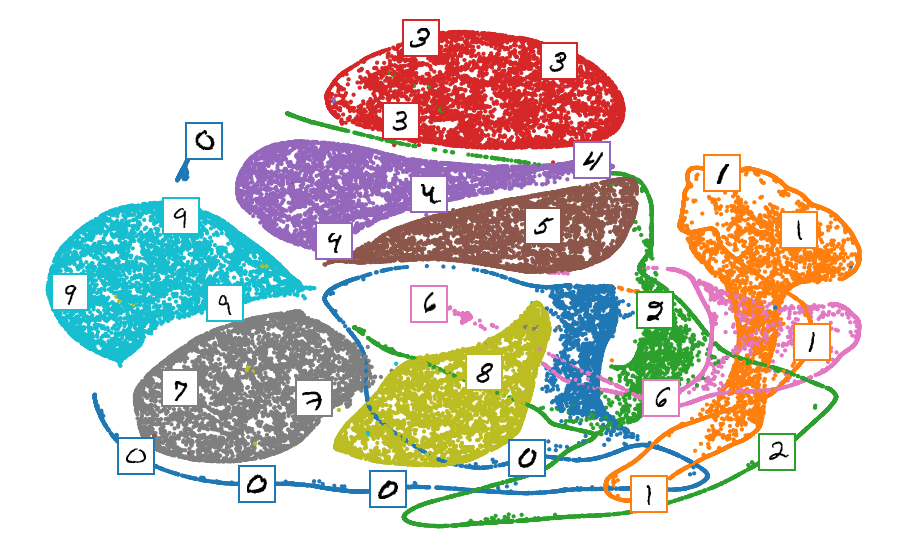

In [346]:
plot_tsne(best_model_2, X_train, y_train)

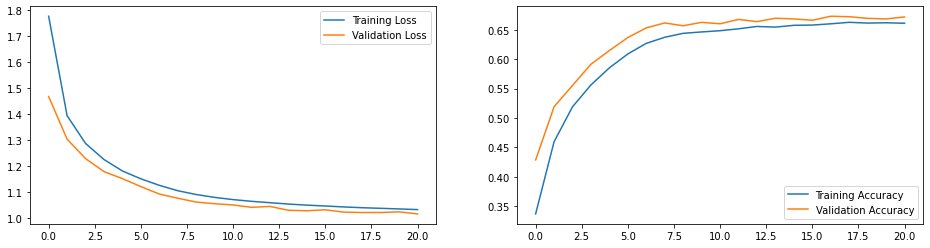

<Figure size 144x144 with 0 Axes>

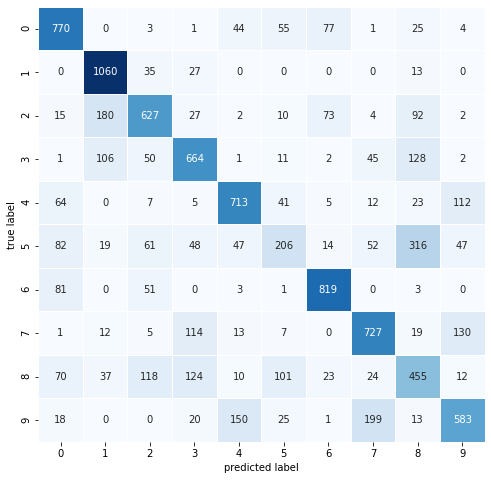

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.00%,5.47%,0.01%,0.16%,0.00%,90.24%,0.14%,3.97%
1,2.59%,0.52%,41.27%,0.30%,0.04%,2.64%,46.74%,0.01%,5.87%,0.03%
2,0.00%,70.31%,16.32%,9.09%,0.00%,0.43%,0.01%,0.04%,3.81%,0.00%
3,72.72%,0.00%,1.52%,0.04%,4.68%,4.70%,13.05%,0.02%,2.86%,0.41%
4,9.57%,0.00%,0.04%,0.44%,45.61%,14.06%,0.00%,2.44%,4.86%,22.97%


In [366]:
plot_metrics(best_model_2, best_hist_2, X_test)

In [1]:
import pickle
import pandas as pd

# Experiment 3 - Best Model

In [ ]:
# Loading experiments performed in another notebook
results_df = pickle.load(open('reg_results.pkl', 'rb'))
results_df['Experiment Name'] = results_df['Experiment Name'].str.replace('Experiment ','None ')

pca_results_df = pickle.load(open('fixed_origina_experiment_PCA_with_F1.pkl', 'rb'))
pca_results_df['Experiment Name'] = pca_results_df['Experiment Name'].str.replace('Experiment ','PCA ')

rf_results_df = pickle.load(open('rf_results_df.pkl', 'rb'))
rf_results_df['Experiment Name'] = rf_results_df['Experiment Name'].str.replace('Experiment ','Rand Forest ')

combined_results = pd.concat([results_df,pca_results_df,rf_results_df], axis=0)
combined_results.reset_index(drop=True, inplace=True)
combined_results= combined_results.rename(columns={'Experiment Name': 'Dim Reduction'})
combined_results['Activation'][combined_results['Activation'].str.contains('selu')]='SELU'
combined_results['Activation'][combined_results['Activation'].str.contains('relu')]='ReLU'
combined_results['Activation'][combined_results['Activation'].str.contains('tanh')]='Tanh'
combined_results['Activation'][combined_results['Activation'].str.contains('sigmoid')]='Sigmoid'
combined_results.to_csv('combined_results.csv')

## Top model without dimension reduction

In [48]:
# Top model without dim reduction
combined_results.iloc[:,:-3][combined_results['Dim Reduction'].str.contains('None')].sort_values('test_F1', 
                                                                                                 ascending=False).head(1)

,Dim Reduction,Hidden Nodes,Activation,Completed Epochs,Optimizer,batch_size,loss,acc,F1,val_loss,val_acc,val_F1,test_loss,test_acc,test_F1,Learning Rate,Beta 1,Epsilon
190,None 191,64,ReLU,37,nadam,256,0.105,0.984,0.984,0.123,0.98,0.98,0.121,0.978,0.978,NaN,NaN,NaN


In [ ]:
# Search space for hyperparameters - used in experiments 3-5
params = {'hid_nodes': [64], 
          'batch_size': [256], 
          'activation':[tf.nn.relu],       
          'learning_rate':[None],
          'optimizer':['madam'],
          'epsilon':[None],
          'beta_1':[None]}

In [38]:
# Full 784 input dims - No reduction
iter_dict = [dict(zip(params, v)) for v in product(*params.values())]
experiment_3_results, exp_3_model, exp_3_hist, exp_3_model_name = experiment_loop('None', 
                                                                                  data_list, 
                                                                                  iter_dict, 
                                                                                  input_nodes = 784, 
                                                                                  epochs = 150);


Epoch 1/150
215/215 [==============================] - 1s 2ms/step - loss: 0.6409 - accuracy: 0.8543 - state_full_binary_fbeta: 0.8521 - val_loss: 0.3629 - val_accuracy: 0.9224 - val_state_full_binary_fbeta: 0.9204
Epoch 2/150
215/215 [==============================] - 0s 2ms/step - loss: 0.3431 - accuracy: 0.9259 - state_full_binary_fbeta: 0.9249 - val_loss: 0.2958 - val_accuracy: 0.9384 - val_state_full_binary_fbeta: 0.9372
Epoch 3/150
215/215 [==============================] - 0s 2ms/step - loss: 0.2915 - accuracy: 0.9386 - state_full_binary_fbeta: 0.9379 - val_loss: 0.2655 - val_accuracy: 0.9494 - val_state_full_binary_fbeta: 0.9485
Epoch 4/150
215/215 [==============================] - 0s 2ms/step - loss: 0.2588 - accuracy: 0.9473 - state_full_binary_fbeta: 0.9467 - val_loss: 0.2371 - val_accuracy: 0.9526 - val_state_full_binary_fbeta: 0.9518
Epoch 5/150
215/215 [==============================] - 0s 2ms/step - loss: 0.2355 - accuracy: 0.9528 - state_full_binary_fbeta: 0.9524 - val

In [86]:
experiment_3_results

,Experiment Name,Hidden Nodes,Activation,Completed Epochs,Optimizer,batch_size,Learning Rate,Beta 1,Epsilon,loss,acc,F1,val_loss,val_acc,val_F1,test_loss,test_acc,test_F1
0,None 1,64,<function relu at 0x00000256C7E8D678>,27,NADAM,256,None,None,None,0.124,0.98,0.98,0.134,0.976,0.976,0.133,0.975,0.975


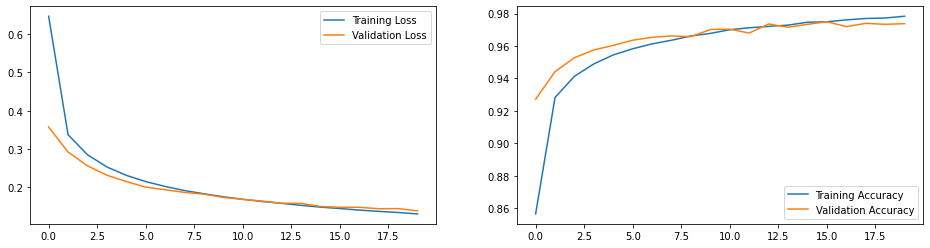

<Figure size 144x144 with 0 Axes>

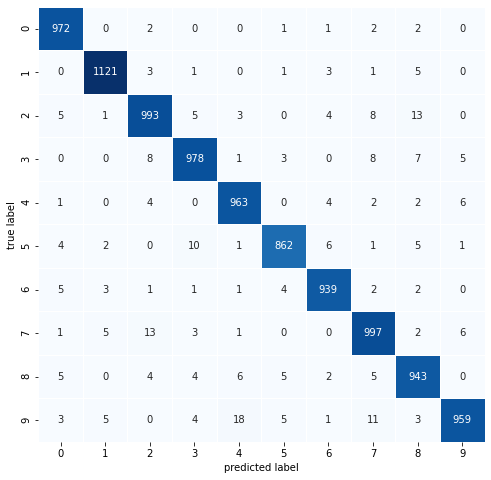

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.01%,0.01%,0.00%,0.00%,0.00%,99.97%,0.00%,0.00%
1,0.05%,0.02%,99.81%,0.06%,0.00%,0.00%,0.02%,0.00%,0.03%,0.00%
2,0.01%,98.81%,0.29%,0.03%,0.06%,0.04%,0.05%,0.39%,0.30%,0.02%
3,99.91%,0.00%,0.03%,0.00%,0.00%,0.02%,0.02%,0.01%,0.00%,0.01%
4,0.01%,0.00%,0.01%,0.00%,99.13%,0.00%,0.03%,0.06%,0.01%,0.74%


In [66]:
plot_metrics(exp_3_model, exp_3_hist, X_test)

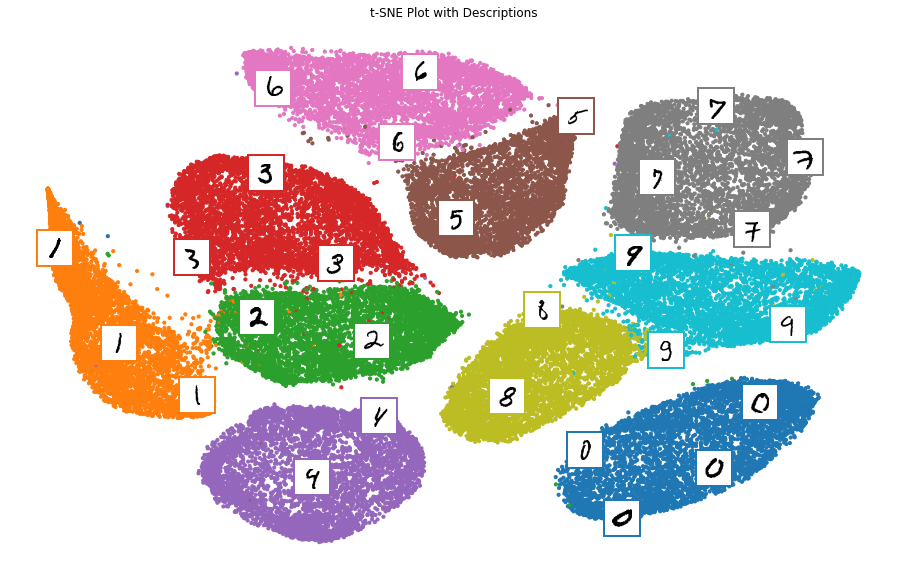

In [51]:
plot_tsne(exp_3_model, X_train, y_train_scalar)

# Experiment 4 - PCA


## Principal Component Analysis

Determine number of pricipal components that explains ~95% of variance

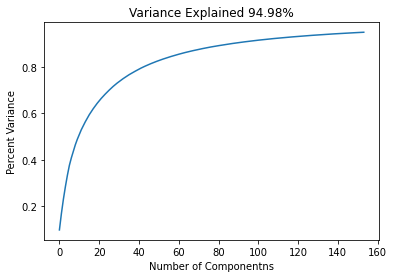

,Principle Comp,Variance Squared
0,0,9.399609e-03
1,1,5.004342e-03
2,2,3.814315e-03
3,3,2.910785e-03
4,4,2.383345e-03
5,5,1.851083e-03
6,6,1.064526e-03
7,7,8.308539e-04
8,8,7.648444e-04
9,9,5.585869e-04


In [432]:
pca_plot(X_train, 154)

In [52]:
# Fit PCA on training set and transform validation and test data 
pca_train = PCA(n_components=174)
pca_X_train = pca_train.fit_transform(X_train)

pca_X_val = pca_train.transform(X_val)

pca_test = PCA(n_components=174)
pca_X_test = pca_train.transform(X_test)

# Add X datasets to list for helper functions
pca_data_list = [pca_X_train, pca_X_val, pca_X_test]



In [53]:
# Create list to pass in relevent X values and train model
pca_data_list = [pca_X_train, pca_X_val, pca_X_test]
pca_results_df, pca_model, pca_hist, pca_name = experiment_loop('PCA', 
                                                                pca_data_list, 
                                                                iter_dict, 
                                                                input_nodes = 174, 
                                                                epochs = 150)


Epoch 1/150
215/215 [==============================] - 0s 2ms/step - loss: 1.1184 - accuracy: 0.7313 - state_full_binary_fbeta: 0.7262 - val_loss: 0.4635 - val_accuracy: 0.9098 - val_state_full_binary_fbeta: 0.9083
Epoch 2/150
215/215 [==============================] - 0s 2ms/step - loss: 0.3873 - accuracy: 0.9175 - state_full_binary_fbeta: 0.9166 - val_loss: 0.3165 - val_accuracy: 0.9330 - val_state_full_binary_fbeta: 0.9317
Epoch 3/150
215/215 [==============================] - 0s 2ms/step - loss: 0.2975 - accuracy: 0.9358 - state_full_binary_fbeta: 0.9351 - val_loss: 0.2654 - val_accuracy: 0.9418 - val_state_full_binary_fbeta: 0.9407
Epoch 4/150
215/215 [==============================] - 0s 2ms/step - loss: 0.2551 - accuracy: 0.9456 - state_full_binary_fbeta: 0.9451 - val_loss: 0.2363 - val_accuracy: 0.9536 - val_state_full_binary_fbeta: 0.9528
Epoch 5/150
215/215 [==============================] - 0s 2ms/step - loss: 0.2280 - accuracy: 0.9525 - state_full_binary_fbeta: 0.9521 - val

In [64]:
# Performance details
pca_results_df

,Experiment Name,Hidden Nodes,Activation,Completed Epochs,Optimizer,batch_size,Learning Rate,Beta 1,Epsilon,loss,acc,F1,val_loss,val_acc,val_F1,test_loss,test_acc,test_F1
0,PCA 1,64,<function relu at 0x00000256C7E8D678>,34,NADAM,256,None,None,None,0.099,0.985,0.985,0.116,0.98,0.98,0.113,0.977,0.977


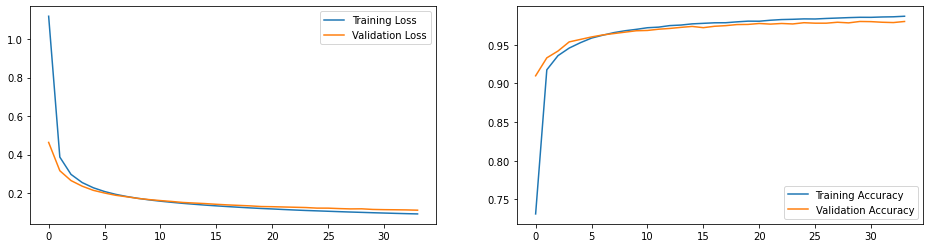

<Figure size 144x144 with 0 Axes>

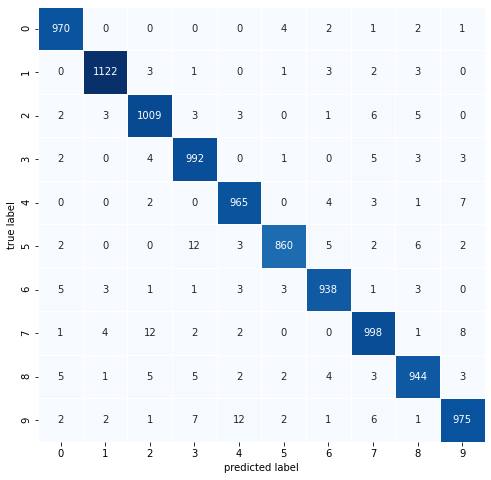

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.01%,0.12%,0.00%,0.00%,0.00%,99.85%,0.00%,0.02%
1,0.00%,0.06%,99.83%,0.09%,0.00%,0.00%,0.00%,0.00%,0.01%,0.00%
2,0.00%,98.82%,0.34%,0.06%,0.07%,0.06%,0.07%,0.33%,0.23%,0.02%
3,99.85%,0.00%,0.12%,0.01%,0.00%,0.00%,0.01%,0.01%,0.00%,0.00%
4,0.01%,0.00%,0.02%,0.00%,99.56%,0.00%,0.01%,0.03%,0.00%,0.37%


In [57]:
plot_metrics(pca_model, pca_hist, pca_X_test)


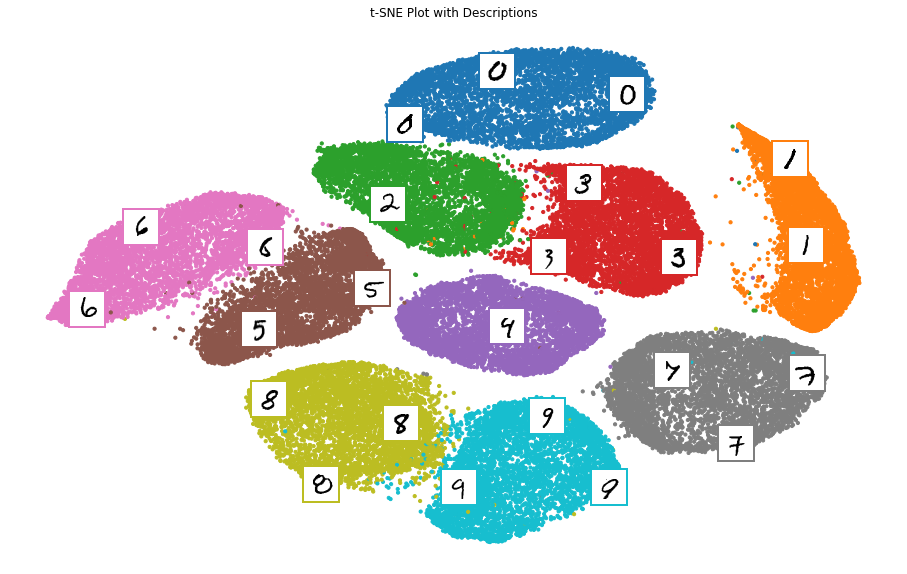

In [67]:
plot_tsne(pca_model, pca_X_train, X_train, y_train_scalar)

# Experiment 5 - Random Forest 
## Random Forest Feature Importances 
Determine the most important 70 input features (pixles )

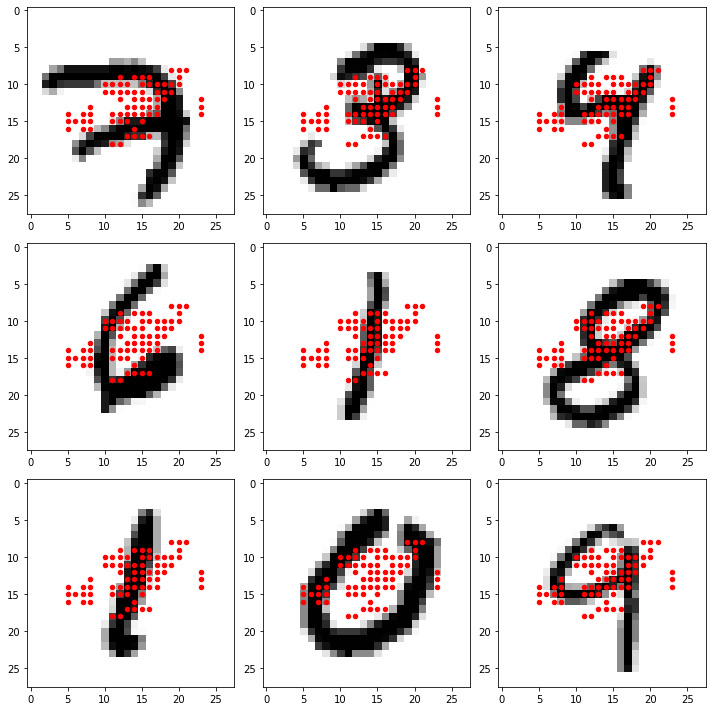

In [68]:
# Fit random forest on training data using 100 trees
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_train,y_train)

top_n_features = 70

# Get indices of top 70 features/pixels
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:top_n_features] 

# Plot feature importances over training examples
plt.figure(figsize=(10,10))
for index in range(9):
    plt.subplot(3, 3, 1+index)

    plt.imshow(X_train[index].reshape(28,28),cmap='binary')
    x, y = np.array([pair(k,28) for k in idx]).T
    plt.scatter(x,y,color='red',s=20)
plt.tight_layout()
plt.show()



In [69]:
# Subset training data to only the most important 70 features
rf_X_train = X_train[:,idx]
rf_X_val = X_val[:,idx]
rf_X_test = X_test[:,idx]

# Add X datasets to list for helper functions
rf_data_list = [rf_X_train, rf_X_val, rf_X_test]

In [84]:
# Full 784 input dims - No reduction
rf_exp_5_df, rf_exp_5_model, rf_exp_5_hist, rf_exp_5_name = experiment_loop('None', 
                                                                              rf_data_list, 
                                                                              iter_dict, 
                                                                              input_nodes = 70, 
                                                                              epochs = 150)

Epoch 1/150
215/215 [==============================] - 0s 2ms/step - loss: 1.1461 - accuracy: 0.6852 - state_full_binary_fbeta: 0.6816 - val_loss: 0.7147 - val_accuracy: 0.8156 - val_state_full_binary_fbeta: 0.8102
Epoch 2/150
215/215 [==============================] - 0s 2ms/step - loss: 0.6780 - accuracy: 0.8221 - state_full_binary_fbeta: 0.8188 - val_loss: 0.6128 - val_accuracy: 0.8424 - val_state_full_binary_fbeta: 0.8383
Epoch 3/150
215/215 [==============================] - 0s 2ms/step - loss: 0.6104 - accuracy: 0.8429 - state_full_binary_fbeta: 0.8402 - val_loss: 0.5656 - val_accuracy: 0.8588 - val_state_full_binary_fbeta: 0.8556
Epoch 4/150
215/215 [==============================] - 0s 2ms/step - loss: 0.5677 - accuracy: 0.8554 - state_full_binary_fbeta: 0.8530 - val_loss: 0.5323 - val_accuracy: 0.8684 - val_state_full_binary_fbeta: 0.8653
Epoch 5/150
215/215 [==============================] - 0s 2ms/step - loss: 0.5345 - accuracy: 0.8658 - state_full_binary_fbeta: 0.8635 - val

In [87]:
rf_exp_5_df

,Experiment Name,Hidden Nodes,Activation,Completed Epochs,Optimizer,batch_size,Learning Rate,Beta 1,Epsilon,loss,acc,F1,val_loss,val_acc,val_F1,test_loss,test_acc,test_F1
0,None 1,64,<function relu at 0x00000256C7E8D678>,32,NADAM,256,None,None,None,0.32,0.924,0.923,0.319,0.927,0.926,0.313,0.925,0.924


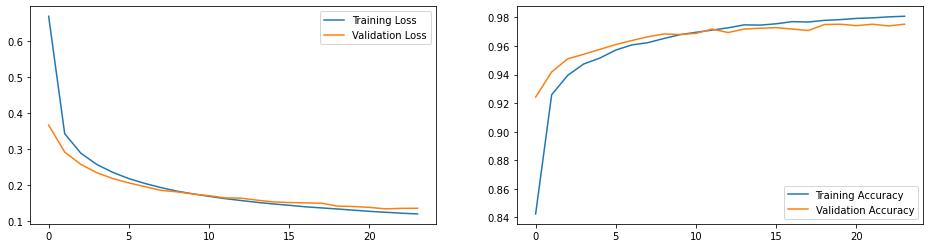

<Figure size 144x144 with 0 Axes>

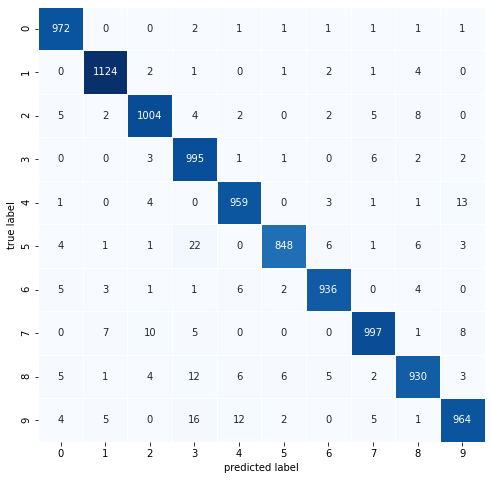

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.02%,0.23%,0.00%,0.00%,0.00%,99.73%,0.01%,0.02%
1,0.02%,0.11%,99.46%,0.32%,0.00%,0.01%,0.01%,0.00%,0.08%,0.00%
2,0.00%,99.38%,0.05%,0.05%,0.03%,0.03%,0.05%,0.28%,0.12%,0.01%
3,99.96%,0.00%,0.02%,0.00%,0.00%,0.00%,0.01%,0.01%,0.00%,0.00%
4,0.01%,0.00%,0.01%,0.00%,99.52%,0.00%,0.01%,0.07%,0.00%,0.38%


In [75]:
plot_metrics(rf_exp_5_model, rf_exp_5_hist, X_test)

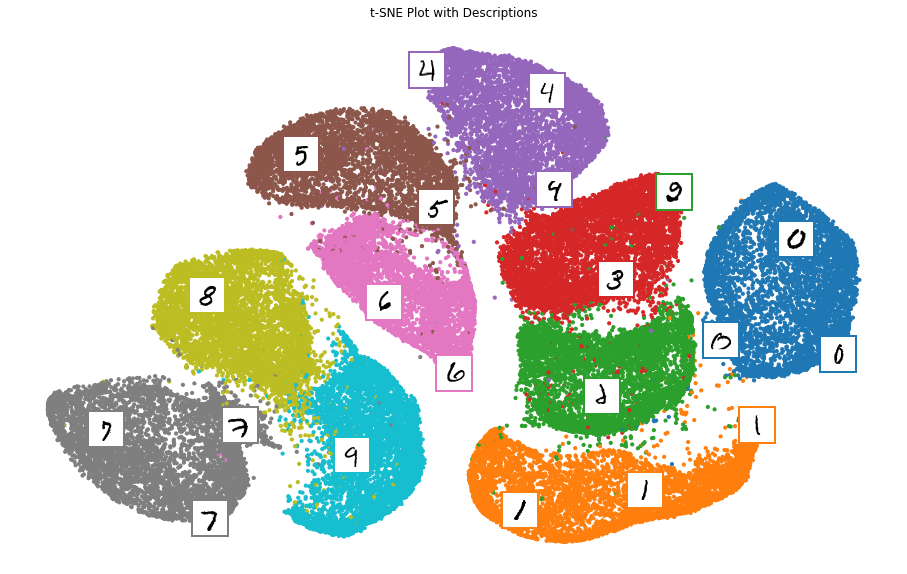

In [85]:
plot_tsne(rf_exp_5_model, rf_X_train, X_train, y_train_scalar)

# Experiment 6 
## Full factorial mixed level design of experiments

In [91]:
# Top 8 models across all dim reduction strategies:
combined_results.iloc[:,:-3].sort_values('test_F1', ascending=False).head(8)

,Dim Reduction,Hidden Nodes,Activation,Completed Epochs,Optimizer,batch_size,loss,acc,F1,val_loss,val_acc,val_F1,test_loss,test_acc,test_F1
499,PCA 244,512,ReLU,18,rmsprop,256,0.084,0.989,0.989,0.101,0.985,0.985,0.099,0.983,0.982
480,PCA 225,512,ReLU,14,nadam,128,0.108,0.985,0.985,0.117,0.983,0.983,0.112,0.981,0.981
449,PCA 194,512,ReLU,10,adam,16,0.155,0.977,0.977,0.158,0.980,0.980,0.142,0.980,0.980
483,PCA 228,512,ReLU,17,rmsprop,128,0.086,0.988,0.988,0.102,0.984,0.983,0.104,0.980,0.980
481,PCA 226,512,ReLU,12,adam,128,0.118,0.982,0.982,0.126,0.982,0.981,0.117,0.980,0.980
497,PCA 242,512,ReLU,16,adam,256,0.108,0.984,0.984,0.119,0.982,0.982,0.113,0.980,0.980
496,PCA 241,512,ReLU,16,nadam,256,0.107,0.985,0.985,0.119,0.983,0.982,0.111,0.980,0.980
417,PCA 162,64,ReLU,24,adam,128,0.102,0.984,0.984,0.117,0.980,0.980,0.111,0.979,0.979
